# Exploration for corpus stats and initial topic modeling experiments

In [1]:
from pathlib import Path

import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer 
import seaborn as sns

import topic_modeling.tokenization as tokenization
from topic_modeling.analysis import *

# Read corpus

In [2]:
CORPUS_DIR = Path('/home/virginia/workspace/topic-modeling-study/russian_novels')
DOCS_TSV = CORPUS_DIR / 'russian_novels.tsv'
STOP_LIST = CORPUS_DIR / 'russian_novels_stopped.txt'
ORIGINAL_WORD_COUNTS = CORPUS_DIR / 'russian_novels_counts.tsv'


In [3]:
print("Original word counts")
original_word_counts = pd.read_csv(ORIGINAL_WORD_COUNTS, sep='\t', encoding='utf-8', names=['word','term_freq', 'doc_freq']) 
display(original_word_counts.head())
keep_set_for_cleaning = set(original_word_counts['word'])
print("Original vocabulary size:", len(keep_set_for_cleaning))


Original word counts


,word,term_freq,doc_freq
0,и,247754,10296
1,не,122673,10285
2,на,91762,10259
3,что,88897,10173
4,в,145809,10011


Original vocabulary size: 319459


In [4]:
stops = get_token_list(STOP_LIST)
print("Number of words pruned from vocab:", len(stops))
print("Vocabulary size after pruning:", len(keep_set_for_cleaning) - len(stops))

Number of words pruned from vocab: 238919
Vocabulary size after pruning: 80540


In [5]:
# Count how many stop word tokens are actually removed
stop_word_series = pd.DataFrame({'word':list(stops)})
original_stop_counts = pd.merge(stop_word_series, original_word_counts, on='word')
original_stop_counts.sort_values(by=['term_freq'], inplace=True, ascending=False)

print("Total number of tokens dropped by pruning:", original_stop_counts['term_freq'].sum())

Total number of tokens dropped by pruning: 2759861


In [6]:
corpus = pd.read_csv(DOCS_TSV, sep='\t', encoding='utf-8', names=['doc_id', 'author', 'text'], index_col=0)
corpus['author'] = corpus['author'].astype('category')

In [7]:
print("Number of documents:", len(corpus.index))
print("Number of authors:", len(set(corpus['author'])))
corpus.head()

Number of documents: 10303
Number of authors: 23


,author,text
doc_id,,
Turgenev_Rudin_0,Turgenev,I Было тихое летнее утро. Солнце уже довольно ...
Turgenev_Rudin_1,Turgenev,"-- Ну, прощай, Матрена! -- проговорила Алексан..."
Turgenev_Rudin_2,Turgenev,Александра Павловна отправилась тихонько назад...
Turgenev_Rudin_3,Turgenev,"-- Вас Дарья Михайловна ко мне прислала, говор..."
Turgenev_Rudin_4,Turgenev,"-- Ступай, барин, право... Константин Диомидыч..."


In [8]:
# We have to downcase and clean up numbers and other non-word things that Mallet eliminates
corpus['clean_text'] = corpus['text'].apply(get_clean_text, args=(keep_set_for_cleaning,))
corpus.head(2)

,author,text,clean_text
doc_id,,,
Turgenev_Rudin_0,Turgenev,I Было тихое летнее утро. Солнце уже довольно ...,i было тихое летнее утро солнце уже довольно в...
Turgenev_Rudin_1,Turgenev,"-- Ну, прощай, Матрена! -- проговорила Алексан...",ну прощай матрена проговорила александра павло...


In [9]:
corpus['stopped_text'] = corpus['clean_text'].apply(get_stopped_text, args=(stops,))
corpus.head(2)

,author,text,clean_text,stopped_text
doc_id,,,,
Turgenev_Rudin_0,Turgenev,I Было тихое летнее утро. Солнце уже довольно ...,i было тихое летнее утро солнце уже довольно в...,i тихое летнее утро солнце довольно высоко сто...
Turgenev_Rudin_1,Turgenev,"-- Ну, прощай, Матрена! -- проговорила Алексан...",ну прощай матрена проговорила александра павло...,прощай матрена проговорила александра павловна...


In [10]:
corpus['doc_length'] = corpus['clean_text'].apply(get_num_tokens)
corpus['stopped_length'] = corpus['stopped_text'].apply(get_num_tokens)
corpus.head(2)

,author,text,clean_text,stopped_text,doc_length,stopped_length
doc_id,,,,,,
Turgenev_Rudin_0,Turgenev,I Было тихое летнее утро. Солнце уже довольно ...,i было тихое летнее утро солнце уже довольно в...,i тихое летнее утро солнце довольно высоко сто...,484,279
Turgenev_Rudin_1,Turgenev,"-- Ну, прощай, Матрена! -- проговорила Алексан...",ну прощай матрена проговорила александра павло...,прощай матрена проговорила александра павловна...,477,250


# Corpus statistics
## Original (unpruned) corpus
Corpus is https://github.com/ginic/RussianNovels/tree/cleanups


In [11]:
print("Total documents:", len(corpus))
print("Document length statistics:")
print("Total tokens:", corpus['doc_length'].sum())
print("Original vocabulary size:", len(keep_set_for_cleaning))
corpus['doc_length'].describe()

Total documents: 10303
Document length statistics:
Total tokens: 6077219
Original vocabulary size: 319459


count    10303.000000
mean       589.849461
std        313.693456
min          0.000000
25%        481.000000
50%        496.000000
75%        553.000000
max       6724.000000
Name: doc_length, dtype: float64

In [12]:
by_author_stats = get_by_author_statistics(corpus, 'author', 'doc_length')
by_author_stats.head()

,author,doc_count,token_count,normalized_doc_length
0,Bulgakov,585,286943,490.500855
1,Chekhov,123,65328,531.121951
2,Dostoyevsky,1271,907836,714.269079
3,Durova,290,231520,798.344828
4,Gan,52,36791,707.519231


In [13]:
docs_by_author = by_author_stats.sort_values('doc_count', ascending=False)
print("How many documents do we have for each author?")
docs_by_author['doc_count'].describe()

How many documents do we have for each author?


count      23.000000
mean      447.956522
std       478.334846
min        15.000000
25%       128.000000
50%       224.000000
75%       591.500000
max      1570.000000
Name: doc_count, dtype: float64

In [14]:
print("Most prolific by docs")
display(docs_by_author.head())
print("Least prolific by docs")
display(docs_by_author.tail())

Most prolific by docs


,author,doc_count,token_count,normalized_doc_length
7,Gorky,1570,775515,493.958599
14,Sholokhov,1301,627038,481.966180
2,Dostoyevsky,1271,907836,714.269079
10,Nabokov,1121,898399,801.426405
16,Tolstoi,1064,608568,571.962406


Least prolific by docs


,author,doc_count,token_count,normalized_doc_length
13,SKhvoshchinskaya,77,43415,563.831169
21,Zhukova,56,35281,630.017857
4,Gan,52,36791,707.519231
19,Volkonskaya,25,13130,525.200000
22,Zinovieva-Annibal,15,7193,479.533333


<AxesSubplot:xlabel='doc_count', ylabel='author'>

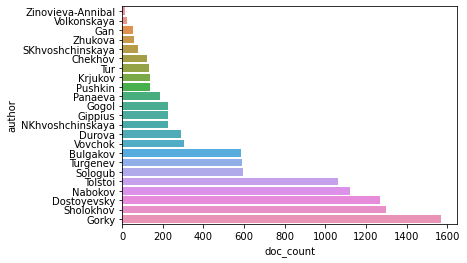

In [15]:
sns.barplot(data=by_author_stats, y='author', x='doc_count', order=by_author_stats.sort_values('doc_count').author)

In [16]:
print("How many tokens do we have for each author?")
tokens_by_author = by_author_stats.sort_values('token_count', ascending=False)
tokens_by_author['token_count'].describe()

How many tokens do we have for each author?


count        23.000000
mean     264226.913043
std      289840.447034
min        7193.000000
25%       69750.000000
50%      121883.000000
75%      316136.000000
max      907836.000000
Name: token_count, dtype: float64

In [17]:
print("Most prolific by tokens")
display(tokens_by_author.head())
print("Least prolific by tokens")
display(tokens_by_author.tail())

Most prolific by tokens


,author,doc_count,token_count,normalized_doc_length
2,Dostoyevsky,1271,907836,714.269079
10,Nabokov,1121,898399,801.426405
7,Gorky,1570,775515,493.958599
14,Sholokhov,1301,627038,481.966180
16,Tolstoi,1064,608568,571.962406


Least prolific by tokens


,author,doc_count,token_count,normalized_doc_length
13,SKhvoshchinskaya,77,43415,563.831169
4,Gan,52,36791,707.519231
21,Zhukova,56,35281,630.017857
19,Volkonskaya,25,13130,525.200000
22,Zinovieva-Annibal,15,7193,479.533333


<AxesSubplot:xlabel='token_count', ylabel='author'>

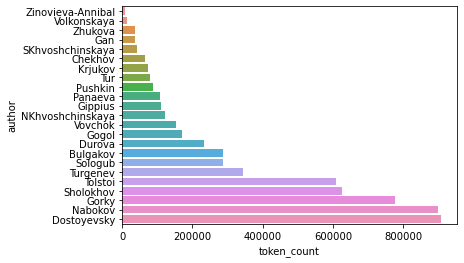

In [18]:
sns.barplot(data=tokens_by_author, y='author', x='token_count', order=tokens_by_author.sort_values('token_count').author)

In [19]:
print("Are there some authors that tend to have longer, 'denser' paragraphs/documents?")
by_author_stats['normalized_doc_length'].describe()


Are there some authors that tend to have longer, 'denser' paragraphs/documents?


count     23.000000
mean     588.438106
std      102.716520
min      479.533333
25%      502.279406
50%      563.831169
75%      634.320523
max      801.426405
Name: normalized_doc_length, dtype: float64

<AxesSubplot:xlabel='normalized_doc_length', ylabel='author'>

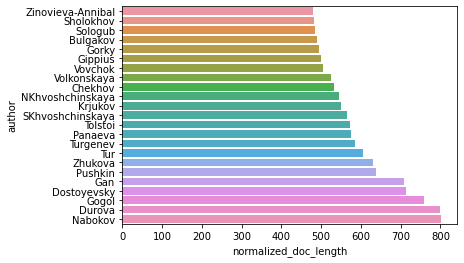

In [20]:
sns.barplot(data=tokens_by_author, y='author', x='normalized_doc_length', order=tokens_by_author.sort_values('normalized_doc_length').author)

In [21]:
# TODO Are there words that are unique to a particular author? 
# TODO Are there authors that use certain words at significantly higher rates than others?
clean_word_counts = get_by_author_word_counts(corpus, 'clean_text', 'author')
clean_word_counts.head()

/home/virginia/miniconda3/envs/topic_modeling/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass input=<bound method RegexTokenizer.tokenize of <topic_modeling.tokenization.RegexTokenizer object at 0x7f4b3766a750>> as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


,Gogol,Turgenev,Gan,Panaeva,Dostoyevsky,Sholokhov,Zhukova,Volkonskaya,Pushkin,Gippius,...,Nabokov,Vovchok,Bulgakov,Chekhov,Durova,Gorky,Krjukov,NKhvoshchinskaya,Tolstoi,Zinovieva-Annibal
aaa,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
ab,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
abbasi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
abencerage,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
# Visualization piece: 1d strip plot seaborn
# token count / total author words 
# y is randomly placed vertically so you can see them

# Comparing pre-lemmatization and post-lemmatization for terms 
# Later: Gamma dist with variance and mean

## Pruned corpus
Mallet corpus was pruned using the following settings:
- `MIN_TERM_FREQ := 5`: A term is pruned if it appears in less than 5 documents
 - `MIN_IDF := 1.39`: For Mallet, a given term's idf = ln(|corpus|/doc_freq), so 1.39 is 25% of corpus. Terms are pruned if they are in more than 25% of documents

Prune by running: `mallet prune --input input.mallet --output output_pruned.mallet --min-idf $(MIN_IDF) --prune-count $(MIN_TERM_FREQ)`


In [23]:
PRUNED_COUNTS = CORPUS_DIR / 'russian_novels_pruned_counts.tsv'
pruned_counts = pd.read_csv(PRUNED_COUNTS, sep='\t', encoding='utf-8', names=['word','term_freq', 'doc_freq']) 
display(pruned_counts.head())
print("Total tokens in pruned corpus according to Mallet (should be close to 'Total tokens' in next cell):", pruned_counts['term_freq'].sum())

,word,term_freq,doc_freq
0,совсем,3618,2554
1,стал,3395,2549
2,этой,3205,2518
3,которые,3638,2509
4,много,3355,2492


Total tokens in pruned corpus according to Mallet (should be close to 'Total tokens' in next cell): 3321349


TODO: Tokenization differences likely account for the differences between what I got and Mallet, should probably pull the regex over from Mallet instead of just splitting on whitespace:
https://github.com/mimno/Mallet/blob/12487de1aa6433bdcf5af0ee0a17b368e64c7acf/src/cc/mallet/classify/tui/Csv2Vectors.java#L110

In [24]:
print("Document length statistics:")
print("Total tokens:", corpus['stopped_length'].sum())
display(corpus['stopped_length'].describe())
print("Total number of tokens dropped by pruning:", original_stop_counts['term_freq'].sum())
print("Vocabulary size after pruning:", len(pruned_counts['word']))

Document length statistics:
Total tokens: 3319694


count    10303.000000
mean       322.206542
std        166.564159
min          0.000000
25%        260.000000
50%        281.000000
75%        311.000000
max       3345.000000
Name: stopped_length, dtype: float64

Total number of tokens dropped by pruning: 2759861
Vocabulary size after pruning: 80540


In [25]:
pruned_counts_by_author = by_author_stats = get_by_author_statistics(corpus, 'author', 'stopped_length')
pruned_counts_by_author['token_count'].describe()

count        23.000000
mean     144334.521739
std      156891.792137
min        3634.000000
25%       38302.000000
50%       65271.000000
75%      174178.000000
max      488050.000000
Name: token_count, dtype: float64

In [26]:
print("Most prolific by tokens after pruning")
display(pruned_counts_by_author.head())
print("Least prolific by tokens after pruning")
display(pruned_counts_by_author.tail())

Most prolific by tokens after pruning


,author,doc_count,token_count,normalized_doc_length
0,Bulgakov,585,161613,276.261538
1,Chekhov,123,34905,283.780488
2,Dostoyevsky,1271,463093,364.353265
3,Durova,290,128088,441.682759
4,Gan,52,20685,397.788462


Least prolific by tokens after pruning


,author,doc_count,token_count,normalized_doc_length
18,Turgenev,589,185742,315.351443
19,Volkonskaya,25,7067,282.680000
20,Vovchok,305,83181,272.724590
21,Zhukova,56,19256,343.857143
22,Zinovieva-Annibal,15,3634,242.266667


<AxesSubplot:xlabel='token_count', ylabel='author'>

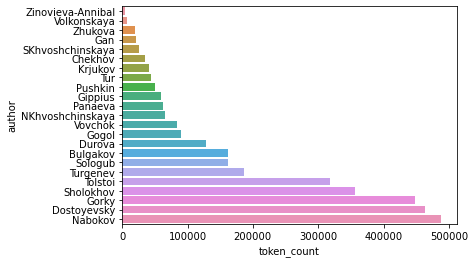

In [27]:
sns.barplot(data=pruned_counts_by_author, y='author', x='token_count', order=pruned_counts_by_author.sort_values('token_count').author)

In [28]:
print("Normalized token counts after pruning")
print("Are there some authors that tend to have longer, 'denser' paragraphs/documents?")
pruned_counts_by_author['normalized_doc_length'].describe()


Normalized token counts after pruning
Are there some authors that tend to have longer, 'denser' paragraphs/documents?


count     23.000000
mean     322.666739
std       55.713645
min      242.266667
25%      279.470769
50%      308.881481
75%      353.671325
max      441.682759
Name: normalized_doc_length, dtype: float64

<AxesSubplot:xlabel='normalized_doc_length', ylabel='author'>

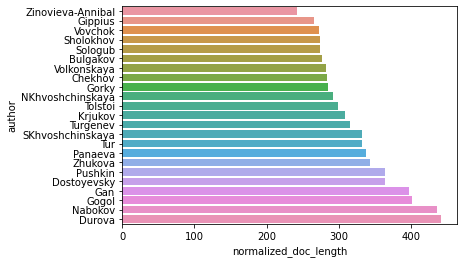

In [29]:
sns.barplot(data=pruned_counts_by_author, y='author', x='normalized_doc_length', order=pruned_counts_by_author.sort_values('normalized_doc_length').author)

In [30]:
stop_word_counts = get_by_author_word_counts(corpus, 'stopped_text', 'author')
stop_word_counts.head()

/home/virginia/miniconda3/envs/topic_modeling/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass input=<bound method RegexTokenizer.tokenize of <topic_modeling.tokenization.RegexTokenizer object at 0x7f4b3766a750>> as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


,Gogol,Turgenev,Gan,Panaeva,Dostoyevsky,Sholokhov,Zhukova,Volkonskaya,Pushkin,Gippius,...,Nabokov,Vovchok,Bulgakov,Chekhov,Durova,Gorky,Krjukov,NKhvoshchinskaya,Tolstoi,Zinovieva-Annibal
ada,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
adieu,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ah,0.0,5.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,...,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ai,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
aimais,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Analysis of topics
A topic model was trained on the pruned corpus with the following settings:
- `NUM_TOPICS := 100`
- `NUM_ITERS := 1000`
- `OPTIMIZE_INTERVAL := 20`
- `OPTIMIZE_BURN_IN := 50`

Mallet training command:
`mallet train-topics $(MALLET_TOPIC_FLAGS) --input input_pruned.mallet --output-state $(state) --output-model $(output_model) --output-doc-topics $(doc_topics) --output-topic-keys $(topic_keys)`

In [31]:
EXPERIMENT_DIR = Path('/home/virginia/workspace/topic-modeling-study/russian_novels/russian_novels_100topics_1000iters')
# Mallet ouput with manually added comments on topic quality
TOPIC_KEYS = EXPERIMENT_DIR / 'russian_novels_100topics_1000iters_topic_keys_with_comments.tsv'

In [32]:
topics = pd.read_csv(TOPIC_KEYS, sep='\t', encoding='utf-8', index_col=0)
topics.head()

,topic_proportion_per_doc,tokens,comment
tid,,,
0,0.00610,литвинов ирина прокуратор пилат литвинова поту...,Bulgakov – Master and Margarita
1,0.02477,григорий аксинья пантелей прокофьевич петро на...,Tolstoy – War and Peace
2,0.05131,круг лишь времени пока которой однако столь ны...,connecting words and adverbs topic (but also ‘...
3,0.04771,чтоб ж б наконец графиня надобно граф однако с...,"particle and adverb topic, very common words (..."
4,0.00955,цинциннат м-сье пьер маменька дедушка ивановна...,"family members, names and titles"


## Author entropy
Produced with command:
`python ~/workspace/authorless-tms/topic_author_correlation.py --input russian_novels.tsv --vocab russian_novels_pruned_vocab.txt --input-state russian_novels_100topics_1000iters/russian_novels_100topics_1000iters.gz --output russian_novels_100topics_1000iters/russian_novels_100topics_1000iters_author_correlation.tsv`


In [33]:
AUTHOR_CORRELS = EXPERIMENT_DIR /'russian_novels_100topics_1000iters_author_correlation.tsv'

In [34]:
author_correls = pd.read_csv(AUTHOR_CORRELS, sep='\t', encoding='utf-8', index_col=0)
author_correls.head()

,Author Entropy,Minus Major Author,Balanced Authors
Topic,,,
0,0.904924,0.244517,0.434387
1,0.265061,0.412718,0.404191
2,0.579936,0.233994,0.283639
3,1.300572,0.083752,0.098598
4,1.596524,0.145853,0.274923


<AxesSubplot:xlabel='Author Entropy', ylabel='Count'>

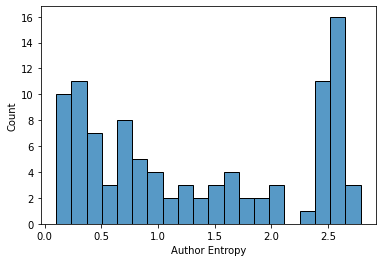

In [35]:
sns.histplot(data=author_correls['Author Entropy'], bins=20)

<AxesSubplot:xlabel='Minus Major Author', ylabel='Count'>

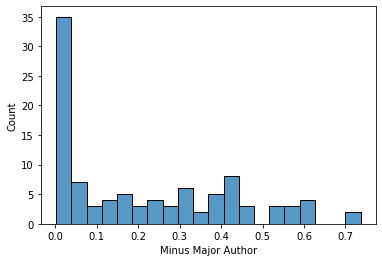

In [36]:
sns.histplot(data=author_correls['Minus Major Author'], bins=20)

<AxesSubplot:xlabel='Balanced Authors', ylabel='Count'>

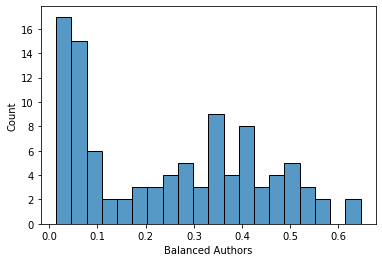

In [37]:
sns.histplot(data=author_correls['Balanced Authors'], bins=20)

In [38]:
# TODO Join in top documents per topic here
topics_with_entropy = pd.merge(topics, author_correls, left_index=True, right_index=True)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
# Sort by increasing entropy - lower entropy means a single author dominates that topic
# Higher Minus Major Author or Balanced Authors means that the distribution changes significantly,
# so a single author is using terms differently from others
topics_with_entropy.sort_values("Author Entropy").head(100)


,topic_proportion_per_doc,tokens,comment,Author Entropy,Minus Major Author,Balanced Authors
tid,,,,,,
23,0.00513,нежданов марианна соломин паклин сипягин маркелов нежданова калломейцев валентина михайловна машурина нежданову промолвил маркелова сипягина татьяна соломина отвечал остродумов алексей,names,0.101041,0.736654,0.645751
52,0.02472,клим лидия клима макаров лютов климу варавка самгин иноков спивак алина туробоев лидии дронов чтоб ответил пред макарова мать диомидов,Klim Sangin,0.147418,0.557213,0.519550
70,0.01266,ван ада вана люсетта марина демон ады the вану аде аду мадемуазель вин ларивьер адой ардис бланш демона лишь and,"Names, Nabokov - Ada",0.166383,0.616731,0.555628
60,0.01236,логин триродов елисавета клавдия логина петр анна остров андозерский мотовилов шестов триродова логину кирша молин тихо словно елена валя глава,"Names, Sologub – Bad Dreams",0.176239,0.596606,0.538629
61,0.00748,граф ея евстафий валериан астольда графа евстафия чтоб кауни лютгарда тодеуш астольды валериана этаго ксендз нибудь однакож клутницкий гедвига торгайло,"count (title), names",0.179681,0.567293,0.508892
92,0.00652,ортруда королева её танкред афра меччио всё королевы ортруды танкреда астольф лорена имогена ещё филиппо виктор принц принца ортруде ортруду,"queen, prince, names",0.183865,0.579977,0.494037
38,0.00695,франц кречмар магда драйер марта горн макс франца нужно быстро кречмара аннелиза драйера тихо автомобиль сейчас бруно глядя подумал господин,Names – Nabokov - Корол,0.184836,0.600660,0.562375
9,0.04684,самгин самгина клим самгину варвара чтоб марина подумал пред снова дронов иванович конечно тагильский вообще затем ответил чорт кутузов сердито,Gorky – the Life of Klim Samgin,0.201651,0.417979,0.429942
10,0.00819,передонов варвара саша людмила володин передонова вершина передонову марта рутилов ардальон думал сердито борисыч грушина словно сашу хрипач надежда владя,"Lots of names, mainly Sologob – Petty Demon",0.224079,0.543726,0.477409


## Morphological analysis of topics
Questions to answer:
- Which topics have multiple words with the same lemma? What about morphological variation on proper names?
- Which lemmas appear frequently across different topics? 
- Which topics contain many words of the same morphological type (e.g. past tense feminine sg verbs)? What types?
- Type-token ratio and character-token ratio broken down by author